# TUTORIAL: 
# Data assimilation using real experimental data

We can now put everything we have learned together. 

We can investigate two scenarios:

A) Assume that we have access to the post-processed data and assimilate it. This situation simplifies the problem as the experimental data is not biased (see tutorial TA_azimuthal_data to see how the raw data is biased).
-   Truth: post-processed data 
-   Observations: post-processed data + noise (possibly coloured noise)

B) Assume a realistic setting in which the post-processed data is not available on the fly to input to the data assimilation algorithm. Here, we need to address the issue of biased observations.
-   Truth: post-processed data
-   Observations: raw data

In this tutorial we will work with option A. For option B go to the tutorial ```11_DA_annular_raw.ipynb```.

In [1]:
import numpy as np
import os

from matplotlib import pyplot as plt

from essentials.physical_models import Annular
from essentials.bias_models import ESN
import scipy.io as sio

rng = np.random.default_rng(0)


if os.path.isdir('/mscott/'):
    data_folder = '/mscott/an553/data/'  # set working directory to 
else:
    data_folder = "../data/"

## 1. Load data 
Create the reference truth and the observations.

The code below can is compacted with the function ```create_truth```
```
  
# Load experimental data
mat = sio.loadmat(filename + '.mat')
y_true, y_raw, t_true = [mat[key].squeeze() for key in ['y_filtered', 'y_raw', 't']]

t_max = 7.
i1 = np.argmin(abs(t_true - t_max))
y_true, y_raw, t_true = [xx[:i1] for xx in [y_true, y_raw, t_true]]
t_true -= t_true[0]

Nt, Nq = y_true.shape
dt_t = t_true[1] - t_true[0]

# Select the observations time-window
t_start = 2. * Annular.t_transient
t_stop = t_start + Annular.t_CR * 20
Nt_obs = 60

# Sample the observations
obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + 1, Nt_obs, dtype=int)
y_obs, t_obs = [xx[obs_idx] for xx in [y_raw, t_true]]
```

The output ```truth``` is a dictionary containing
```
dict(y_raw=y_raw, y_true=y_true, t=t_true, dt=dt_t, t_obs=t_obs, y_obs=y_obs, 
     dt_obs=Nt_obs * dt_t, std_obs=std_obs)
```

In [61]:
from essentials.create import create_truth
ER = 0.5625 # 0.4875 + np.arange(0, 4) * 0.025
truth_params = dict(model = data_folder + 'annular/ER_{}'.format(ER),
                    t_start = 2. * Annular.t_transient,
                    t_stop = 2.1 * Annular.t_transient,
                    Nt_obs = 20,
                    t_max = 7.,
                    post_processed=False
                    )

truth = create_truth(**truth_params)

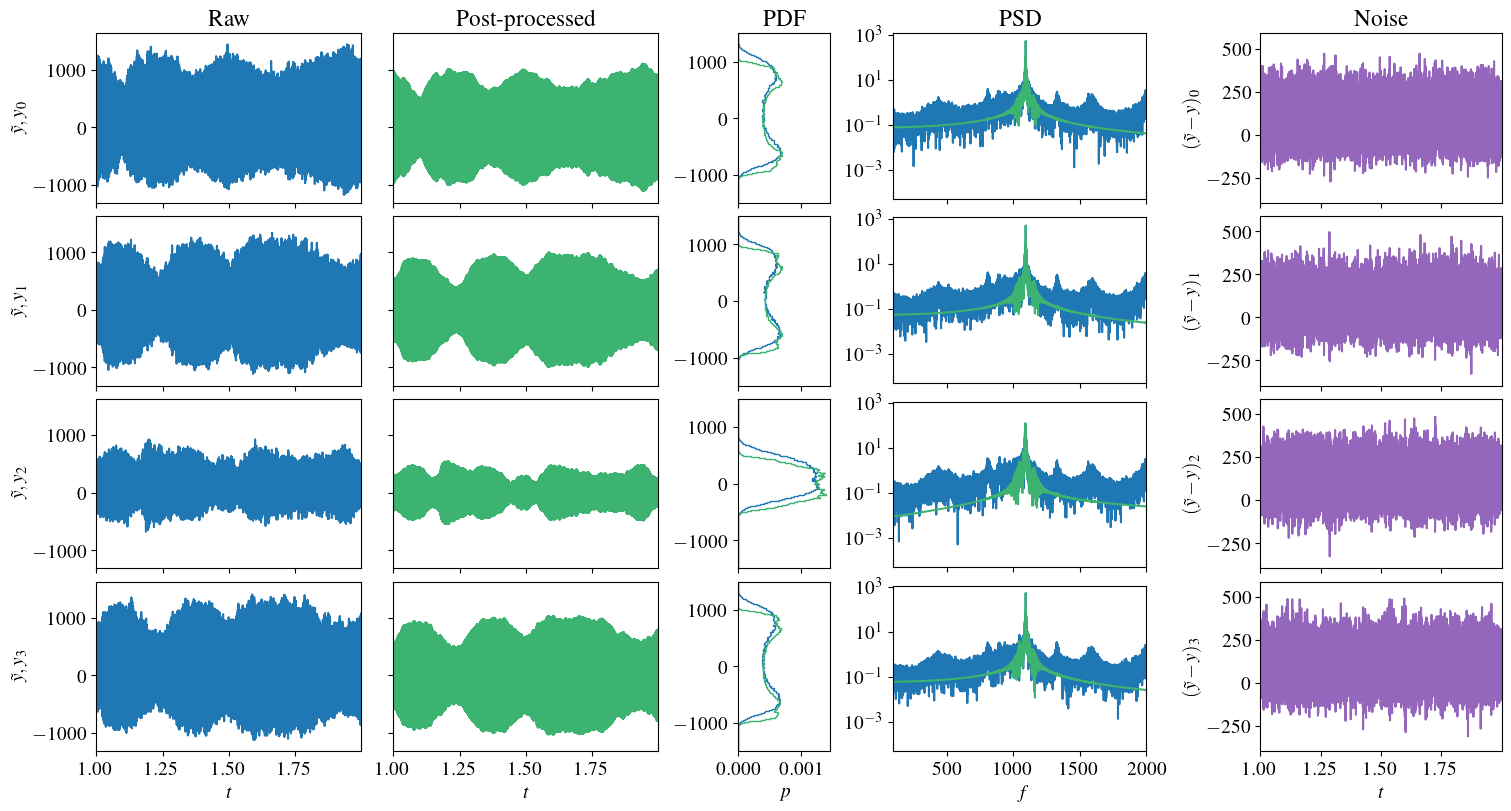

In [3]:
from essentials.plotResults import plot_truth
plot_truth(**truth)

## 2. Define the forecast model
This is the physical model which we will use to model the true data.
Here, we select the filter parameters and create ensemble

*The code below can be compacted as*
```
from essentials.create import create_ensemble
ensemble = create_ensemble(model=Annular, **filter_params)
```

In [46]:
alpha0 = dict(nu=(20., 40.),
              c2beta=(10, 50),
              kappa=(1.E-4, 1.3E-4),
              epsilon=(5e-3, 8e-3),
              omega=(1090 * 2 * np.pi, 1095 * 2 * np.pi),
              theta_b=(0.5, 0.7),
              theta_e=(0.4, 0.6)
              )

alpha0_mean = dict()
for alpha, lims in alpha0.items():
    alpha0_mean[alpha] = 0.5 * (lims[0] + lims[1])

ensemble = Annular(**alpha0_mean)

filter_params = {'m': 20, 
                 'inflation': 1.0,
                 'std_psi': 0.3,
                 'std_a': alpha0}

# Forecast model to initialise the ensemble after transient
state, t_ = ensemble.time_integrate(int(ensemble.t_CR / ensemble.dt))
ensemble.update_history(state[-1], reset=True)

ensemble.init_ensemble(**filter_params)



Visualize ensemble initialization

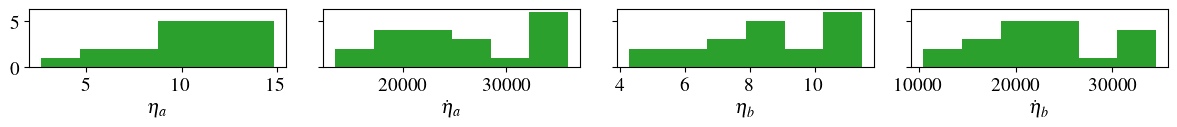

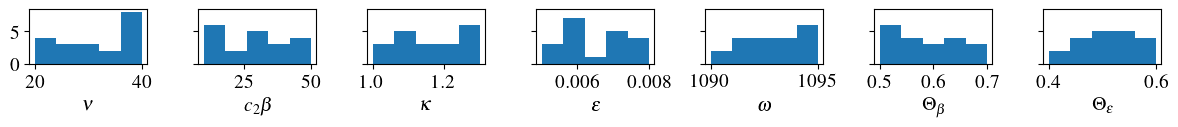

In [6]:
from essentials.plotResults import plot_ensemble
plot_ensemble(ensemble, reference_params={'kappa': 1e-4, 'omega': 2 * np.pi})

## 4. Train an ESN to model the model bias
The procedure is the following

&emsp; i. Initialise ESN Bias class object
&emsp; ii. Create synthetic bias to use as training data 
&emsp; iii. Train the ESN
&emsp; iv. Create washout data

<br><br>
**4.1. Initialise the ESN**

In [7]:
from essentials.create import create_bias_training_dataset

ensemble_no_bias = ensemble.copy()
ensemble_ESN = ensemble.copy()

train_params = dict(bias_model=ESN, 
                    upsample=5,
                    N_units=50,
                    N_wash=5,
                    t_train=ensemble.t_transient,
                    t_test=ensemble.t_CR * 4,
                    t_val=ensemble.t_CR * 4,
                    # Training data generation options
                    augment_data=True,
                    bayesian_update=False,
                    biased_observations=True,
                    seed_W=0,
                    L=50,
                    # Hyperparameter search ranges
                    rho_range=(0.5, 1.),
                    sigma_in_range=(np.log10(1e-5), np.log10(1e1)),
                    tikh_range=[1e-12, 1e-9]
                    )

ensemble_ESN.init_bias(**train_params)


|
**4.2. Create training data**

The details of the code inside ```create_bias_training_dataset()``` function is explained in the tutorial ```Class_Bias.ipynb```.

In [8]:
train_data = create_bias_training_dataset(truth['y_raw'], truth['y_true'], ensemble_ESN, **train_params)


Rerun multi-parameter training data: Increase the length of the training data


Visualize training data


In [9]:
#TODO

print(train_data['data'].shape,
      train_data['observed_idx'],
      )

(150, 37893, 8) [4 5 6 7]



**4.3. Train the ESN**

The training convergence, hyperparameter optimization and testing results are saved in a pdf file in *figs_ESN* folder.


 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 5.000e-01	 1.000e-05	 1.000e-12	 -5.1537
2	 5.000e-01	 1.000e-03	 1.000e-09	 -5.3894
3	 5.000e-01	 1.000e-01	 1.000e-09	 -5.3518
4	 5.000e-01	 1.000e+01	 1.000e-12	 -4.3363
5	 6.667e-01	 1.000e-05	 1.000e-12	 -5.2379
6	 6.667e-01	 1.000e-03	 1.000e-09	 -5.3572
7	 6.667e-01	 1.000e-01	 1.000e-12	 -5.4884
8	 6.667e-01	 1.000e+01	 1.000e-12	 -3.6389
9	 8.333e-01	 1.000e-05	 1.000e-12	 -5.2131
10	 8.333e-01	 1.000e-03	 1.000e-09	 -5.3482
11	 8.333e-01	 1.000e-01	 1.000e-12	 -5.6117
12	 8.333e-01	 1.000e+01	 1.000e-12	 -2.5147
13	 1.000e+00	 1.000e-05	 1.000e-12	 -5.2179
14	 1.000e+00	 1.000e-03	 1.000e-09	 -5.2917
15	 1.000e+00	 1.000e-01	 1.000e-12	 -5.3050
16	 1.000e+00	 1.000e+01	 1.000e-12	 -2.2665
17	 7.567e-01	 6.162e-02	 1.000e-09	 -5.5322
18	 7.131e-01	 1.149e-04	 1.000e-12	 -5.3175
19	 5.000e-01	 7.235e-03	 1.000e-09	 -5.3512
20	 8.030e

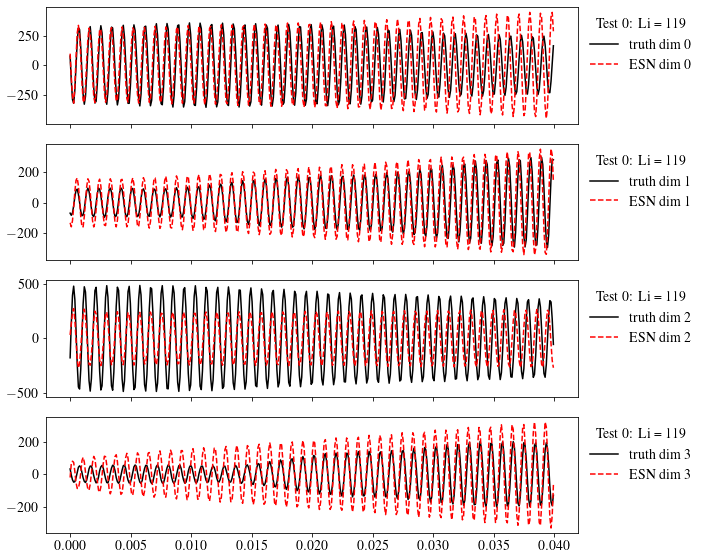

In [10]:
ensemble_ESN.bias.train_bias_model(**train_data)

**4.4. Create washout data**

We retrieve from the raw data a ```N_wash``` number of observations to use for initialising the ESN, i.e., to perform the washout. 
The ESN initialization must be before the fist observation.

```
from essentials.create import create_washout
wash_t, wash_obs = create_washout(ensemble.bias, t=t_true, y_raw=y_raw)
```

In [62]:
ensemble_ESN.bias.t_init = truth['t_obs'][0] - 2 * truth['dt_obs']

i1 = np.argmin(abs(ensemble_ESN.bias.t_init - truth['t']))
i0 = i1 - ensemble_ESN.bias.N_wash  * ensemble_ESN.bias.upsample 

wash_obs = truth['y_raw'][i0:i1 + 1:ensemble_ESN.bias.upsample]
wash_t = truth['t'][i0:i1 + 1:ensemble_ESN.bias.upsample]


## 5. Apply data assimilation
We now have all the ingredients to start our data assimilation algorithm.

In [64]:
from essentials.DA import dataAssimilation
from copy import deepcopy

DA_kwargs = dict(y_obs=truth['y_obs'], t_obs=truth['t_obs'], std_obs=0.1, wash_obs=wash_obs, wash_t=wash_t)


bias = deepcopy(ensemble_ESN.bias)

out = []
for  kf in ['rBA_EnKF', 'EnSRKF']:
    
    ens = ensemble.copy()
    if kf[0] == 'r':
        ens.bias = bias
    
    ens.filter = kf
    ens.regularization_factor = 5.

    ens.t_init = truth['t_obs'][0]
    ens.inflation = 1.001
    
    filter_ens = dataAssimilation(ens, **DA_kwargs.copy())
    
    #Forecast the ensemble further without assimilation
    # Nt_extra = int(filter_ens.t_CR / filter_ens.dt) * 5) 
    Nt_extra = int(.5 / filter_ens.dt)
    
    
    psi, t = filter_ens.time_integrate(Nt_extra)
    filter_ens.update_history(psi, t)
    
    y = filter_ens.get_observable_hist(Nt_extra)
    b, t_b = filter_ens.bias.time_integrate(t=t, y=y)
    filter_ens.bias.update_history(b, t_b)
    
    out.append(filter_ens)
    # out[-1] = filter_ens



 ------------------ Annular Model Parameters ------------------ 
	 ER = 0.5
	 Nq = 4
	 c2beta = 30.0
	 dt = 1.95313e-05
	 epsilon = 0.0065
	 kappa = 0.000115
	 n = 1.0
	 nu = 30.0
	 omega = 6864.38
	 theta_b = 0.6
	 theta_e = 0.5

 ---------------- ESN bias model parameters --------------- 
	 L = 50
	 N_ens = 1
	 N_units = 50
	 N_wash = 5
	 bayesian_update = False
	 biased_observations = True
	 connect = 3
	 observed_idx = [4 5 6 7]
	 perform_test = True
	 rho = 0.8333333333333333
	 sigma_in = 0.1
	 t_train = 0.5
	 t_val = 0.04
	 tikh = 1e-12
	 update_reservoir = False
	 upsample = 5

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = rBA_EnKF  
	 bias = ESN 
 	 m = 20 
 	 Time steps between analysis = None 
 	 Inferred params = ['nu', 'c2beta', 'kappa', 'epsilon', 'omega', 'theta_b', 'theta_e'] 
 	 Inflation = 1.001 
 	 Ensemble std(psi0) = 0.3
 	 Ensemble std(alpha0) = {'nu': (20.0, 40.0), 'c2beta': (10, 50), 'kappa': (0.0001, 0.00013), 'epsilon': (0.005

            omega        nu           c2beta       kappa            epsilon          theta_b        theta_e
----------  -----------  -----------  -----------  ---------------  ---------------  -------------  -------------
Truth       $6848.672$   $25.105625$  $37.02375$   $0.00012$        $0.0023$         $0.63$         $0.66$
rBA_EnKF    $6858.0683   $30.621182   $23.779113   $0.00012094522   $0.0076160051    $0.6563391     $0.50990476
 w/ ESN      \pm 1.88$    \pm 3.503$   \pm 7.055$   \pm 7.142e-06$   \pm 0.0008069$   \pm 0.03646$   \pm 0.03011$
EnSRKF      $6860.1771   $28.362188   $20.67812    $0.0001169248    $0.0075838864    $0.64508249    $0.51623969
 w/ NoBias   \pm 2.413$   \pm 3.503$   \pm 8.65$    \pm 8.536e-06$   \pm 0.0007829$   \pm 0.04859$   \pm 0.03931$


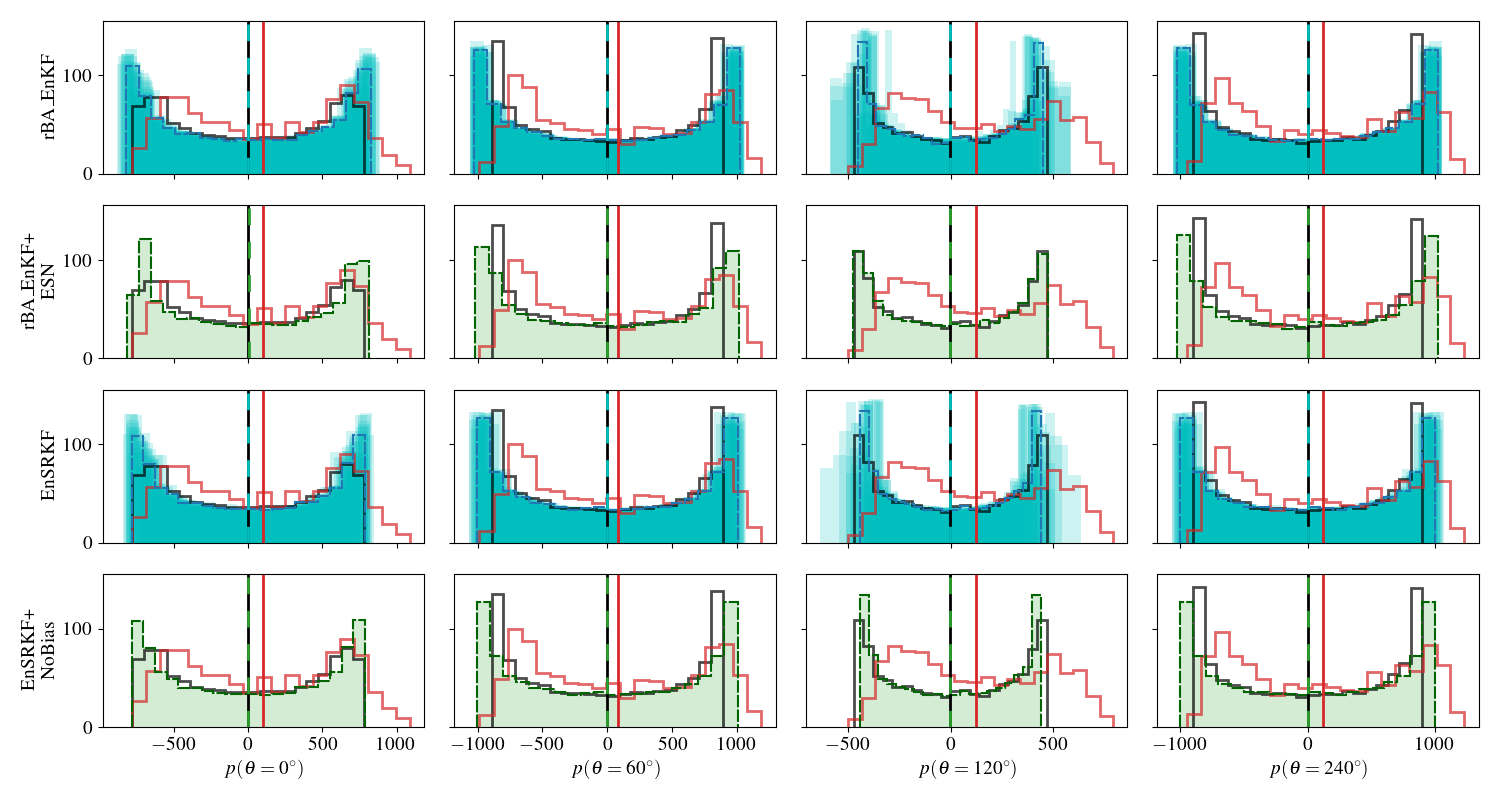

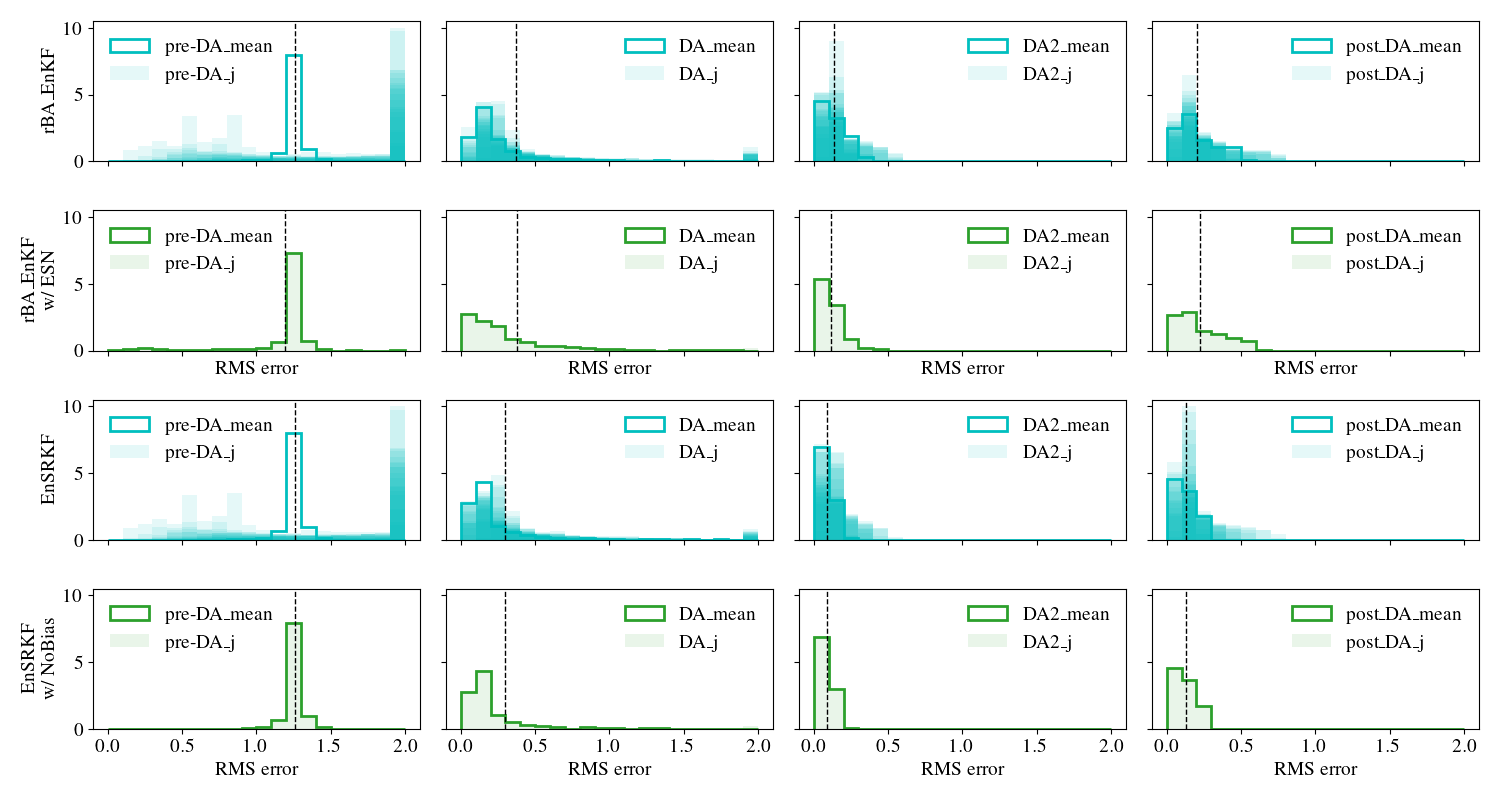

In [65]:
from essentials.plotResults import print_parameter_results
from essentials.plotResults import plot_states_PDF, plot_RMS_pdf

truth_params = dict()
for param in Annular.params:
    if param == 'nu':
        truth_params[param] = Annular.nu_from_ER(ER)
    elif param == 'c2beta':
        truth_params[param] = Annular.c2beta_from_ER(ER)
    else:
        truth_params[param] = Annular.defaults[param]

print_parameter_results(out, true_values=truth_params)
               
truth['wash_t'] = wash_t
truth['wash_obs'] = wash_obs

window = (truth['t_obs'][-1], truth['t_obs'][-1] + out[0].t_CR * 2)
plot_states_PDF(out, truth, nbins=20, window=window)
plot_RMS_pdf(out, truth, nbins=20)

[-1317.249929881342, 1317.249929881342]
[-1317.249929881342, 1317.249929881342]


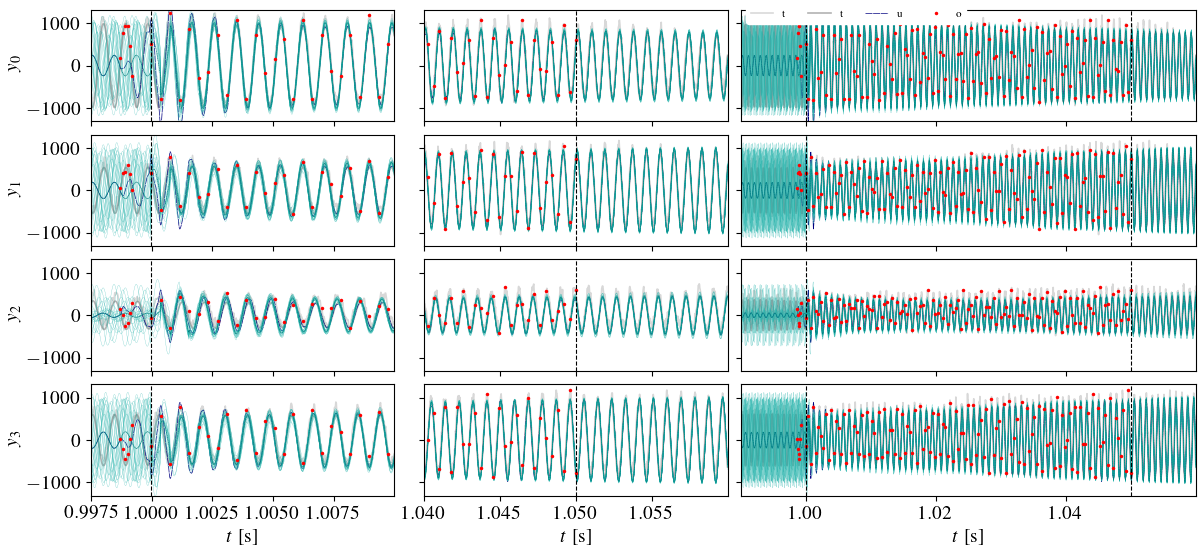

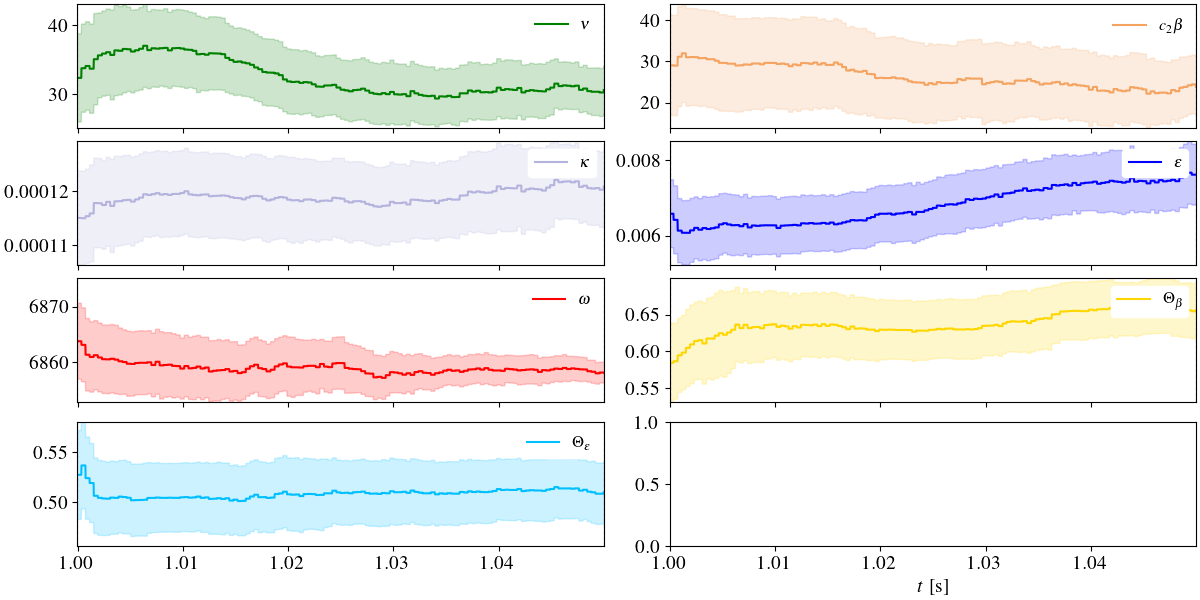

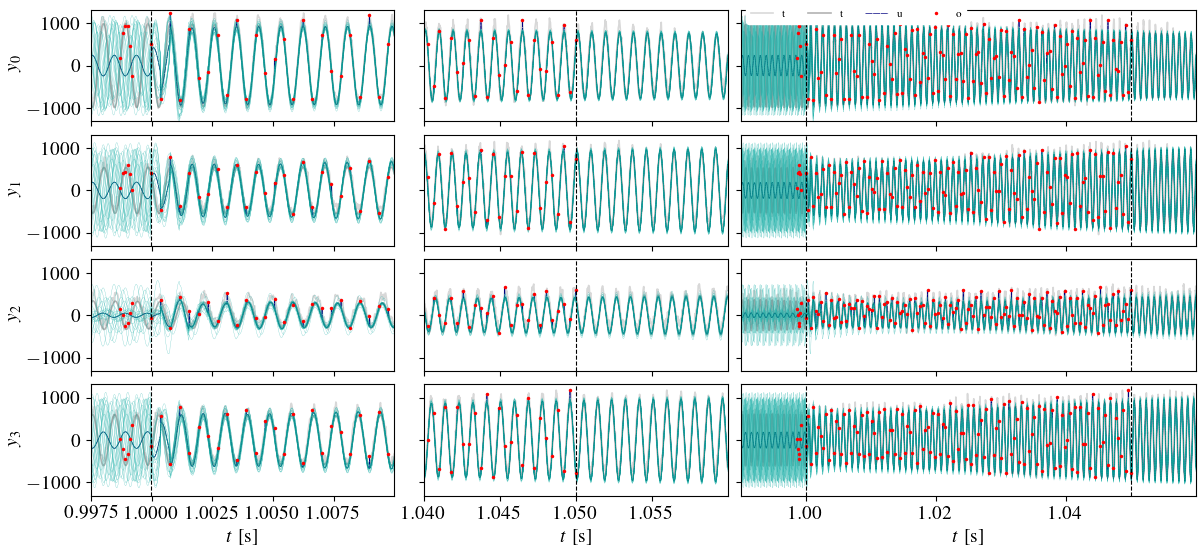

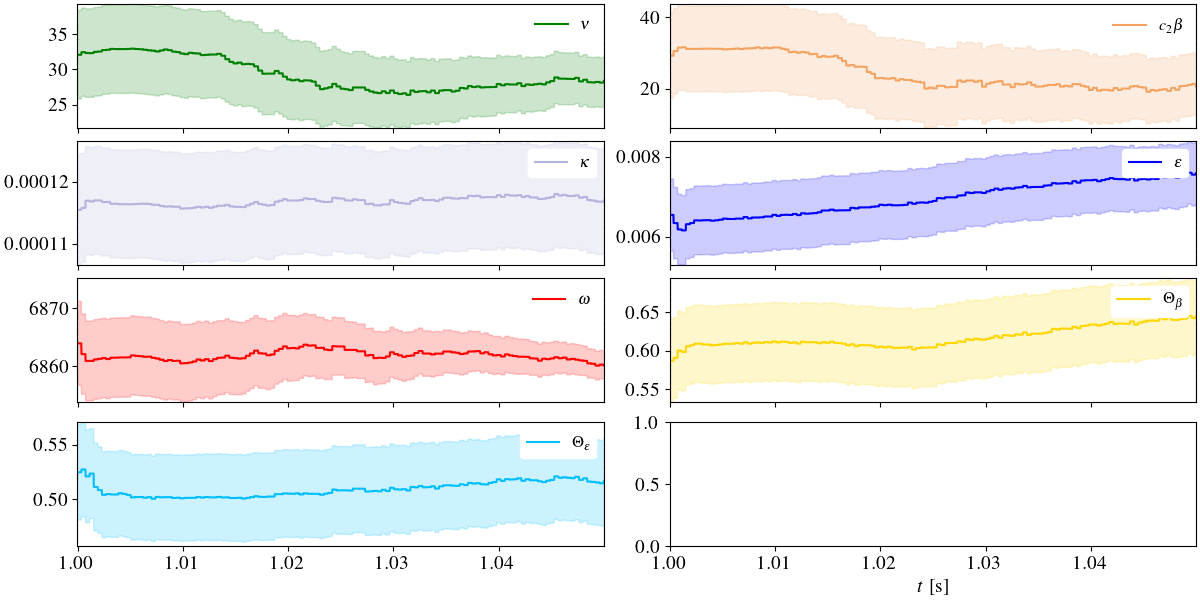

In [66]:
from essentials.plotResults import plot_timeseries, plot_parameters

for filter_ens in out:
    plot_timeseries(filter_ens, truth)
    plot_parameters(filter_ens, truth)

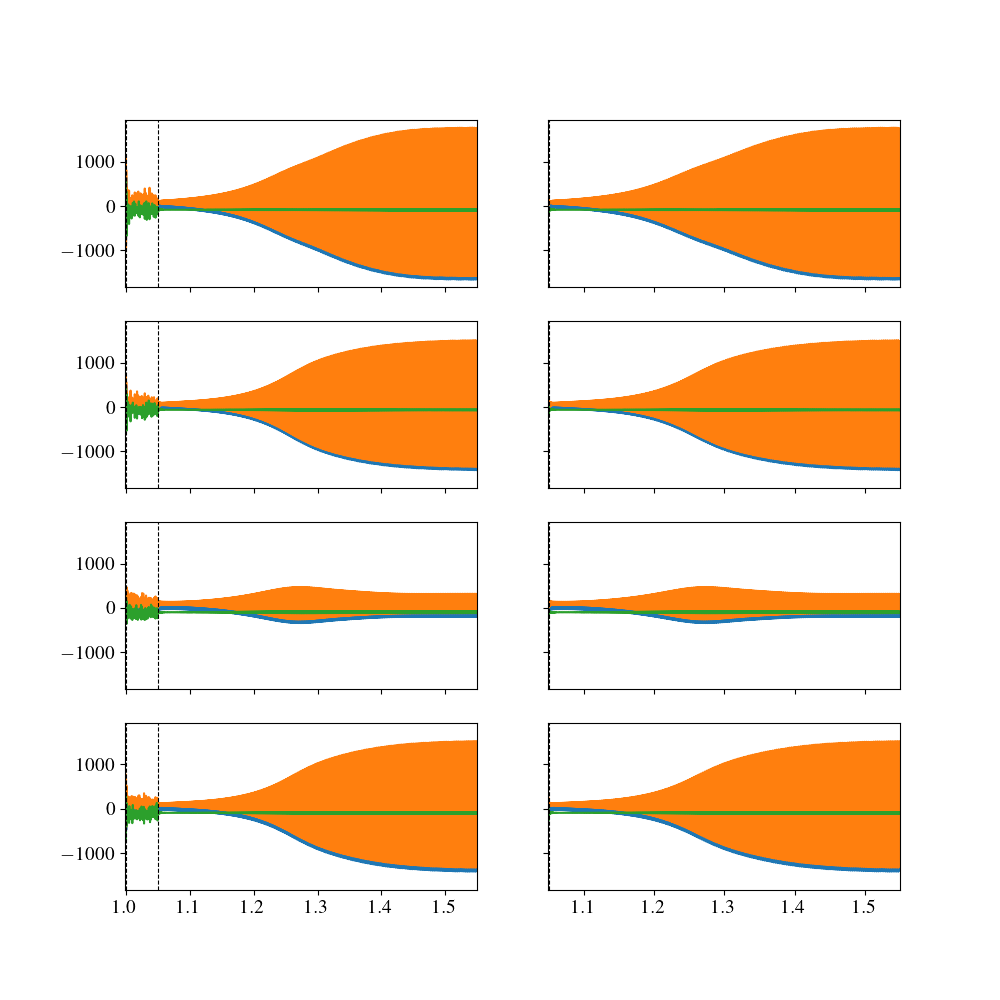

In [67]:
import matplotlib.pyplot as plt

%matplotlib widget

for filter_ens in [out[0]]:
    bias = filter_ens.bias
    ESN_prediction = bias.hist
    bias_hist = bias.get_bias(ESN_prediction)
    inn_hist = ESN_prediction[:, bias.observed_idx]

    xls =  [[DA_kwargs['wash_t'][0], bias.hist_t[-1]], 
            [DA_kwargs['t_obs'][-5], bias.hist_t[-1]]]
    fig, axs = plt.subplots(bias.N_dim_in, 2, sharex='col', sharey=True, figsize=(10, 10))
    for kk, axs_ in enumerate(axs):
        for ax in axs_:
            ax.plot(bias.hist_t, bias_hist[:, kk])
            ax.plot(bias.hist_t, inn_hist[:, kk])
            ax.plot(bias.hist_t, bias_hist[:, kk] - inn_hist[:, kk])
            ax.axvline(x=DA_kwargs['t_obs'][0], ls='--', color='k', linewidth=.8)
            ax.axvline(x=DA_kwargs['t_obs'][-1], ls='--', color='k', linewidth=.8)
    axs[-1, 0].set_xlim(xls[0])
    axs[-1, 1].set_xlim(xls[-1])
#     
    

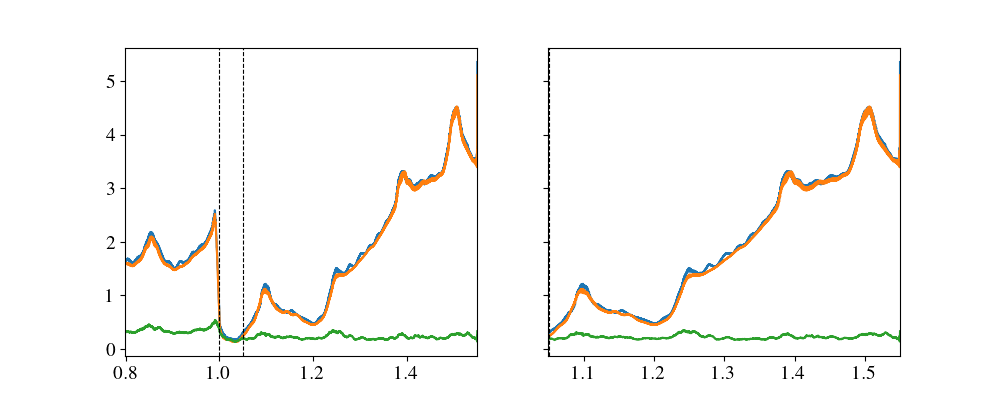

In [68]:
import matplotlib.pyplot as plt
from essentials.Util import interpolate, CR

%matplotlib notebook


for filter_ens in [out[0]]:
    bias = filter_ens.bias
    
    y_raw, y_true =[ np.expand_dims(interpolate(truth['t'], yy, bias.hist_t), axis=-1) for yy in [truth['y_raw'], truth['y_true']]]
    y_filter = filter_ens.get_observable_hist()
    y_filter = interpolate(filter_ens.hist_t, y_filter, bias.hist_t) 
    
    inn_ESN = bias.hist[:, bias.observed_idx]
    b_ESN = bias.get_bias(state=bias.hist)
    bd_ESN = b_ESN - inn_ESN
    
    
    inn_obs = y_raw - y_filter
    b_obs = y_true - y_filter
    bd_obs = y_true - y_raw
    
    inn_RMS = np.sqrt(np.sum((inn_obs - inn_ESN) ** 2, axis=1) / np.sum(y_true ** 2, axis=1))
    b_RMS = np.sqrt(np.sum((b_obs - b_ESN) ** 2, axis=1) / np.sum(y_true ** 2, axis=1))
    bd_RMS = np.sqrt(np.sum((bd_obs - bd_ESN) ** 2, axis=1) / np.sum(y_true ** 2, axis=1))
    

    window = int(filter_ens.t_CR/5 // filter_ens.dt)
    average_RMS_i, average_RMS_b, average_RMS_bd = [], [], []
    average_t = []
    for ind in range(len(inn_RMS)):
        average_RMS_i.append(np.mean(inn_RMS[ind:ind+window]))
        average_RMS_b.append(np.mean(b_RMS[ind:ind+window]))
        average_RMS_bd.append(np.mean(bd_RMS[ind:ind+window]))
        average_t.append(bias.hist_t[ind])


    xls =  [[DA_kwargs['wash_t'][0]-.2, DA_kwargs['wash_t'][-1]+.5], 
            [DA_kwargs['t_obs'][-5], DA_kwargs['t_obs'][-1] + filter_ens.t_CR*2]]
    xls =  [[DA_kwargs['wash_t'][0]-.2, bias.hist_t[-1]], 
            [DA_kwargs['t_obs'][-5], bias.hist_t[-1]]]
    fig, axs = plt.subplots(1, 2, sharex='col', sharey=True, figsize=(10, 4))
    for kk, ax in enumerate(axs):
        # ax.plot(bias.hist_t, inn_RMS)
        ax.plot(average_t, average_RMS_i)
        ax.plot(average_t, average_RMS_b)
        ax.plot(average_t, average_RMS_bd)
        # ax.axhline(y=np.mean(inn_obs[:, kk], axis=0), ls='--', color='g')
        ax.axvline(x=DA_kwargs['t_obs'][0], ls='--', color='k', linewidth=.8)
        ax.axvline(x=DA_kwargs['t_obs'][-1], ls='--', color='k', linewidth=.8)
    axs[0].set_xlim(xls[0])
    axs[1].set_xlim(xls[-1])
    
    

(1.04841796875, 1.549988)

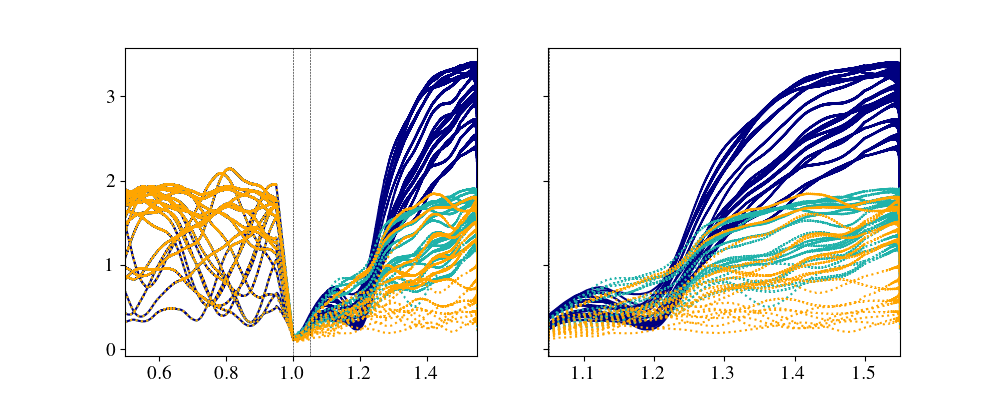

In [69]:
import matplotlib.pyplot as plt
from essentials.Util import interpolate

%matplotlib notebook


for filter_ens in [out[0]]:
    bias = filter_ens.bias
    
    y_raw, y_true =[ np.expand_dims(interpolate(truth['t'], yy, bias.hist_t), axis=-1) for yy in [truth['y_raw'], truth['y_true']]]
    y_filter = filter_ens.get_observable_hist()
    y_filter = interpolate(filter_ens.hist_t, y_filter, bias.hist_t) 
    
    b_ESN = bias.get_bias(state=bias.hist)
    bd_ESN = b_ESN - inn_ESN
    
    y_RMS = np.sqrt(np.sum((y_true - (y_filter + b_ESN)) ** 2, axis=1) / np.max(y_true ** 2))
    Mpsi_RMS = np.sqrt(np.sum((y_true - y_filter) ** 2, axis=1) / np.max(y_true ** 2))
    

    window = int(filter_ens.t_CR // filter_ens.dt)
    average_RMS_y, average_RMS_Mpsi = [], []
    average_t = []
    for ind in range(len(inn_RMS)):
        average_RMS_y.append(np.mean(y_RMS[ind:ind+window], axis=0))
        average_RMS_Mpsi.append(np.mean(Mpsi_RMS[ind:ind+window], axis=0))
        average_t.append(bias.hist_t[ind])

    if len(out) > 1:
        for filter_ens_bb in [out[1]]:
            y_filter = filter_ens_bb.get_observable_hist()
            y_filter = interpolate(filter_ens_bb.hist_t, y_filter, bias.hist_t)
            
            Mpsi_RMS = np.sqrt(np.sum((y_true - y_filter) ** 2, axis=1) / np.max(y_true ** 2))
        
            average_RMS_Mpsi_BB = []
            for ind in range(len(inn_RMS)):
                average_RMS_Mpsi_BB.append(np.mean(Mpsi_RMS[ind:ind+window], axis=0))
    


# xls =  [[DA_kwargs['wash_t'][0]-.2, DA_kwargs['wash_t'][-1]+.5], 
#         [DA_kwargs['t_obs'][-5], DA_kwargs['t_obs'][-1] + filter_ens.t_CR*2]]
xls =  [[DA_kwargs['wash_t'][0]-.5, bias.hist_t[-1]], 
        [DA_kwargs['t_obs'][-5], bias.hist_t[-1]]]
fig, axs = plt.subplots(1, 2, sharex='col', sharey=True, figsize=(10, 4))
for kk, ax in enumerate(axs):
    # ax.plot(bias.hist_t, inn_RMS)
    ax.plot(average_t, average_RMS_y, c='navy')
    ax.plot(average_t, average_RMS_Mpsi, ':', c='lightseagreen')
    
    if len(out) > 1:
        ax.plot(average_t, average_RMS_Mpsi_BB, ':', c='orange')
    # ax.axhline(y=np.mean(inn_obs[:, kk], axis=0), ls='--', color='g')
    ax.axvline(x=DA_kwargs['t_obs'][0], ls='--', color='k', linewidth=.4)
    ax.axvline(x=DA_kwargs['t_obs'][-1], ls='--', color='k', linewidth=.4)
axs[0].set_xlim(xls[0])
axs[1].set_xlim(xls[-1])